In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy . interpolate import UnivariateSpline
import scipy.integrate as integ
from scipy.optimize import root

# Ampliación de Matemáticas. Curso 2021-22.
## Máster INO, ETSI Navales, UPM

## Control 3.

## Nombre, apellidos y DNI: 

> SOLUCIÓN OFICIAL

Los primeros apartados tratan sobre la resolución del siguiente problema de contorno:

$$ -\epsilon^2\ddot{u}(x) + Q(x) u(x) = f(x),\quad -1\leq x \leq 1,$$

siendo $\epsilon$ una constante positiva

$$ u(-1) = u(1) = 0. $$

Arriba, $\ddot{u}$ denota la derivada **segunda** de $u$ con respecto a $x$. Resolveremos este problema para diferentes elecciones de las funciones $Q(x)$ y $f(x)$.

## Apartado 0 (1p.)

Reescribe la ecuación diferencial como un sistema de ecuaciones de orden uno.

> Introducimos `v(x) = dudx(x)` y queda el sistema
> - `dudx(x) = v(x)`
> - `dvdx(x) = (1/epsilon^2) * (Q(x)*u(x) - f(x))`

> (alternativa) escrito en LaTeX:
> $$ \dot{u}(x) = v(x),\quad -1\leq x \leq 1,$$
> $$ \dot{v}(x) = (1/\epsilon^2)  (Q(x)u(x) - f(x)),\quad -1\leq x \leq 1,$$

> (alternativa) en python:
```python
def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
```

## Apartado 1 (2,5p.)

 - (1p.) Resuelve el problema de contorno anterior utilizando ``solve_bvp`` con las siguientes elecciones de $\epsilon$, $Q$ y $f$:
 
 $$ \epsilon = 1,\quad Q(x) = x^2,\quad f(x) = 1. $$
 
 - (1,5p.) Repite el ejercicio anterior con la misma elección de $Q,f$ pero tomando distintos valores de $\epsilon$:
 
 $$ \epsilon = 10^{-n},\quad n=1,2,3,4,5. $$
 
 Representa en ambos casos las gráficas de las soluciones.

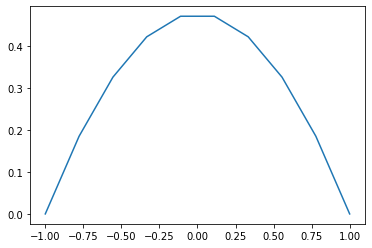

In [2]:
def f(x):
    return 1
def Q(x):
    return x**2
epsilon = 1

def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.plot(sol['x'], sol['y'][0,:])

In [3]:
# Curiosidad (nos lo preguntarán luego)
max(np.abs(sol['y'][0,:]))

0.4702546909066691

 - (1,5p.) Repite el ejercicio anterior con la misma elección de $Q,f$ pero tomando distintos valores de $\epsilon$:
 
 $$ \epsilon = 10^{-n},\quad n=1,2,3,4,5. $$


(0.0, 10000.0)

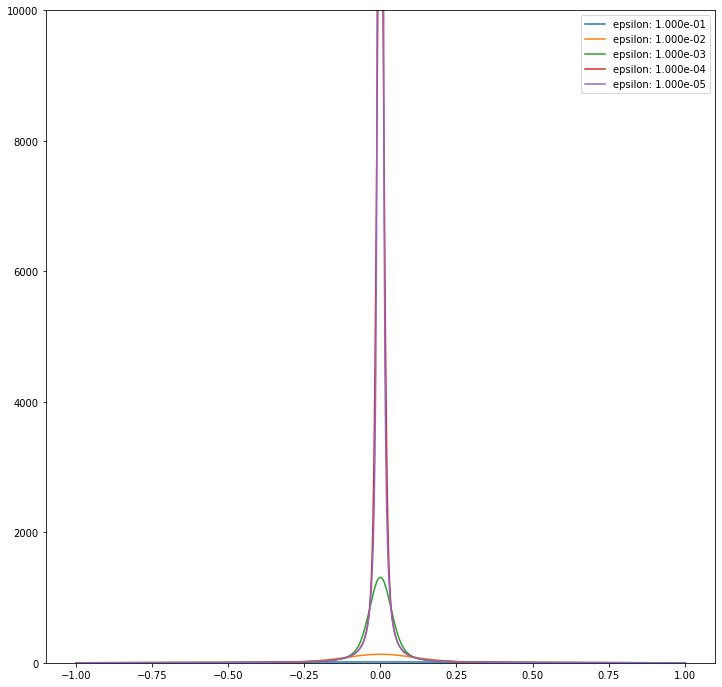

In [4]:
def f(x):
    return 1
def Q(x):
    return x**2
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))

plt.figure(figsize=(12,12))
for epsilon in [10**(-n) for n in range(1,6)]:
    def fun(x, y):
        u, v = y
        return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
    sol = integ.solve_bvp(fun, bc, xs, ys)
    plt.plot(sol['x'], sol['y'][0,:], label='epsilon: %.3e'%epsilon)
plt.legend()
# opcional, pero com ylim se ve más claro el resultado:
plt.ylim(0,1e4)

## Apartado 2 (2,5p.)

Repite el ejercicio del apartado 1 utilizando el método de los elementos finitos.

Reescrimos la ecuación:
$$ -\ddot{u}(x) +(1/\epsilon^2) Q(x) u(x) = (1/\epsilon^2)f(x),\quad -1\leq x \leq 1,$$
para que tenga la forma que usamos al estudiar elementos finitos:
$$
-u'' + Vu = f 
$$


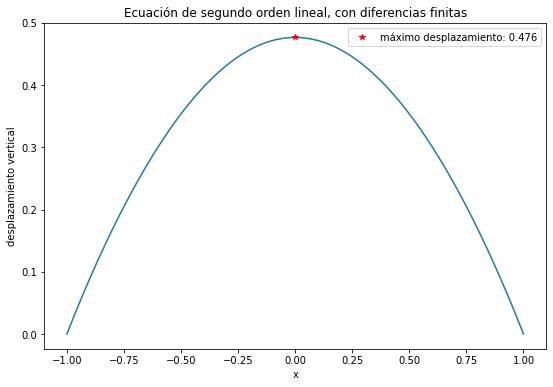

In [5]:
def FE(x1, x2, x3):
    '''Una llamada a FE nos devuelve una función lineal a trozos f
    que vale:
        - f(x1) = f(x3) = 0
        - f(x2) = 1
        - lineal en (x1, x2) y (x2, x3)
        - 0 fuera del intervalo (x1, x3)
    '''
    xdata = [x1-1, x1, x2, x3, x3+1]
    ydata = [0,0,1,0,0]
    # Interpolación lineal a trozos de xdata e ydata
    # continuada por cero entre -oo y x1, y también entre x3 y +oo
    return UnivariateSpline(xdata, ydata, k=1, s=0)

epsilon = 1

#Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
x0, xf = x_span = [-1, 1]
alpha, beta = 0, 0

# y''(x) = p(x) y'(x) + q(x) y(x) + r(x)

def V(x):
    #Devuelve un array del mismo tamaño que el array xs, toma el valor
    #constante S/(E*I)
    return (1/epsilon**2)*x**2

def f(x):
    return -(1/epsilon**2)*np.ones_like(x)

# Probamos distintos valores
n = 120

# Mallado
h = (xf - x0)/n
xs = np.linspace(x0,xf,n+1)
#puntos interiores
xs_int = xs[1:-1]

# Matriz banda A
A = np.zeros((n-1,n-1))
# Vector b
b = np.zeros(n-1)
for i in range(n-1):
    xi = xs_int[i]
    xi_menos = xi - h
    xi_mas   = xi + h
    phi_i = FE(xi_menos, xi, xi_mas)
    A[i,i] = (
        (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
    )
    b[i] = -integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
    if i>0:
        phi_i_menos = FE(xi-2*h, xi-h, xi)
        A[i,i-1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
        )
    if i<n-2:
        phi_i_mas = FE(xi, xi+h, xi+2*h)
        A[i,i+1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
        )

# Solucion
y_int = la.solve(A, b)
ys_FEM = np.zeros(n+1)
# ys_FEM vale 0 en los extremos del intervalo
ys_FEM[1:-1] = y_int

#Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
#graficar el desplazamiento hacia abajo
plt.figure(figsize=(9,6))
plt.plot(xs,ys_FEM)
plt.xlabel('x')
plt.ylabel('desplazamiento vertical')
plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
#Se ve a ojo que el máximo se alcanza en el punto medio
#También se puede deducir de la simetría del problema
#Pero este código permite encontrar el máximo de ys 
#y el punto donde se alcanza el máximo en general
ymax, xmax = max(zip(np.abs(ys_FEM), xs))
#Dibujamos el máximo
plt.plot([xmax], [ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
plt.legend()
plt.show()

> el segundo apartado es hacer lo mismo, pero dentro de un bucle `for`:

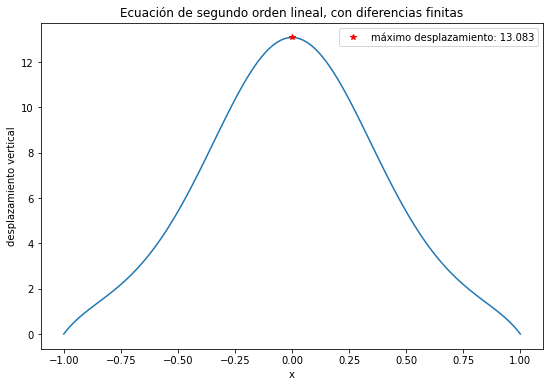

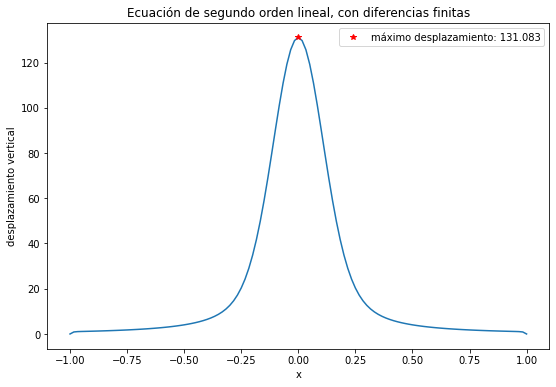

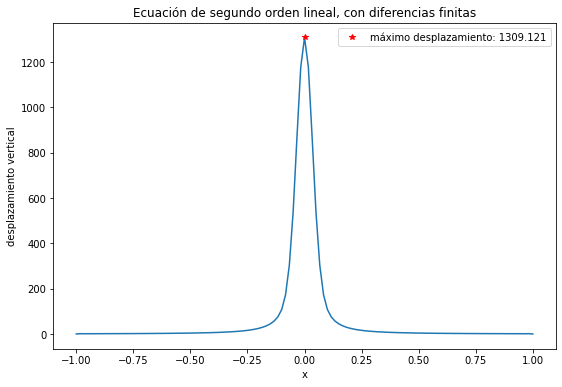

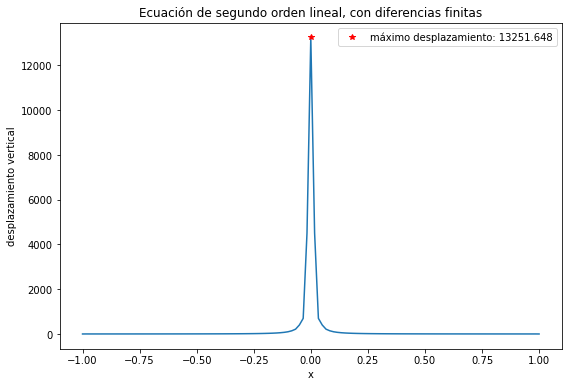

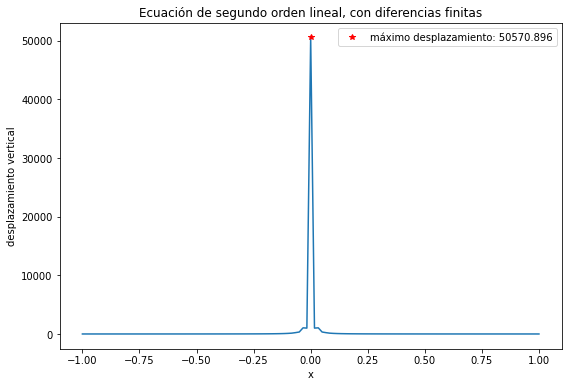

In [6]:
for epsilon in [10**(-n) for n in range(1,6)]:

    #Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
    x0, xf = x_span = [-1, 1]
    alpha, beta = 0, 0

    # y''(x) = p(x) y'(x) + q(x) y(x) + r(x)

    def V(x):
        #Devuelve un array del mismo tamaño que el array xs, toma el valor
        #constante S/(E*I)
        return (1/epsilon**2)*x**2

    def f(x):
        return -(1/epsilon**2)*np.ones_like(x)

    # Probamos distintos valores
    n = 120

    # Mallado
    h = (xf - x0)/n
    xs = np.linspace(x0,xf,n+1)
    #puntos interiores
    xs_int = xs[1:-1]

    # Matriz banda A
    A = np.zeros((n-1,n-1))
    # Vector b
    b = np.zeros(n-1)
    for i in range(n-1):
        xi = xs_int[i]
        xi_menos = xi - h
        xi_mas   = xi + h
        phi_i = FE(xi_menos, xi, xi_mas)
        A[i,i] = (
            (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
        )
        b[i] = -integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
        if i>0:
            phi_i_menos = FE(xi-2*h, xi-h, xi)
            A[i,i-1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
            )
        if i<n-2:
            phi_i_mas = FE(xi, xi+h, xi+2*h)
            A[i,i+1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
            )

    # Solucion
    y_int = la.solve(A, b)
    ys_FEM = np.zeros(n+1)
    # ys_FEM vale 0 en los extremos del intervalo
    ys_FEM[1:-1] = y_int

    #Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
    #graficar el desplazamiento hacia abajo
    plt.figure(figsize=(9,6))
    plt.plot(xs,ys_FEM)
    plt.xlabel('x')
    plt.ylabel('desplazamiento vertical')
    plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
    #Se ve a ojo que el máximo se alcanza en el punto medio
    #También se puede deducir de la simetría del problema
    #Pero este código permite encontrar el máximo de ys 
    #y el punto donde se alcanza el máximo en general
    ymax, xmax = max(zip(np.abs(ys_FEM), xs))
    #Dibujamos el máximo
    plt.plot([xmax], [ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
    plt.legend()
    plt.show()

## Apartado C2.1 (recuperación del control 2)

Aproxima numéricamente, utilizando el método de simpson compuesto, las integrales:

$$ \sqrt{\epsilon}\int_{-1}^1 u_\epsilon(x) dx $$

siendo $u_\epsilon$ las soluciones del problema de contorno anterior correspondientes a 

$$ \epsilon = 10^{-n},\quad n=1,2,3,4,5. $$

> Si usamos `solve_bvp`, tenemos que tener cuidado porque si ponemos pocos puntos en el array `xs` al llamar a `solve_bvp`, el objeto `sol` que devuelve `solve_bvp` puede tener más puntos que el array inicial, y pueden no ser puntos equiespaciados, por lo que no podríamos aplicar la regla de Simpson:

In [7]:
def f(x):
    return 1
def Q(x):
    return x**2
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))

for epsilon in [10**(-n) for n in range(1,6)]:
    def fun(x, y):
        u, v = y
        return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
    sol = integ.solve_bvp(fun, bc, xs, ys)
    print('###', epsilon)
    solx = sol['x']
    print('- n inicial', n, ', solve_bvp devuelve', len(solx))
    print('mínima distancia entre dos puntos de sol["x"]',
          min(solx[j+1]-solx[j] for j in range(len(solx)-1)))
    print('máxima distancia entre dos puntos de sol["x"]',
          max(solx[j+1]-solx[j] for j in range(len(solx)-1)))
    int_simpson = integ.simpson(sol['y'][0,:], sol['x'])
    print(int_simpson*np.sqrt(epsilon))

### 0.1
- n inicial 10 , solve_bvp devuelve 45
mínima distancia entre dos puntos de sol["x"] 0.01851851851851849
máxima distancia entre dos puntos de sol["x"] 0.11111111111111116
3.909703339678524
### 0.01
- n inicial 10 , solve_bvp devuelve 129
mínima distancia entre dos puntos de sol["x"] 0.002057613168724215
máxima distancia entre dos puntos de sol["x"] 0.03703703703703709
4.445456588548917
### 0.001
- n inicial 10 , solve_bvp devuelve 329
mínima distancia entre dos puntos de sol["x"] 0.00022862368541376465
máxima distancia entre dos puntos de sol["x"] 0.012345679012345734
4.584116180473124
### 0.0001
- n inicial 10 , solve_bvp devuelve 973
mínima distancia entre dos puntos de sol["x"] 5.0805263425157676e-05
máxima distancia entre dos puntos de sol["x"] 0.0041152263374485964
4.6276957555972205
### 1e-05
- n inicial 10 , solve_bvp devuelve 730
mínima distancia entre dos puntos de sol["x"] 0.00274348422496562
máxima distancia entre dos puntos de sol["x"] 0.002743484224965842
4.6364763

> - Hay tres posibles soluciones:
>   1. La más sencilla es usar un número mayor de puntos, de modo que `solve_bvp` no necesita añadir nuevos puntos.
>   2. La segunda es basarse en nuestro código de elementos finitos.
>   3. La tercera es interpolar sobre los valores de `solve_bvp`.

> En las tres soluciones es necesario poner un número de puntos grande para que la aproximación a la última integral sea buena.

In [8]:
# Solución #1

def f(x):
    return 1
def Q(x):
    return x**2
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 1000
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))

for epsilon in [10**(-n) for n in range(1,6)]:
    def fun(x, y):
        u, v = y
        return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
    sol = integ.solve_bvp(fun, bc, xs, ys)
    print('###', epsilon)
    solx = sol['x']
    print('- n inicial', n, ', solve_bvp devuelve', len(solx))
    print('mínima distancia entre dos puntos de sol["x"]',
          min(solx[j+1]-solx[j] for j in range(len(solx)-1)))
    print('máxima distancia entre dos puntos de sol["x"]',
          max(solx[j+1]-solx[j] for j in range(len(solx)-1)))
    int_simpson = integ.simpson(sol['y'][0,:], sol['x'])
    print(int_simpson*np.sqrt(epsilon))

### 0.1
- n inicial 1000 , solve_bvp devuelve 1000
mínima distancia entre dos puntos de sol["x"] 0.002002002002001957
máxima distancia entre dos puntos de sol["x"] 0.002002002002002179
3.910229152937734
### 0.01
- n inicial 1000 , solve_bvp devuelve 1000
mínima distancia entre dos puntos de sol["x"] 0.002002002002001957
máxima distancia entre dos puntos de sol["x"] 0.002002002002002179
4.445418907074351
### 0.001
- n inicial 1000 , solve_bvp devuelve 1000
mínima distancia entre dos puntos de sol["x"] 0.002002002002001957
máxima distancia entre dos puntos de sol["x"] 0.002002002002002179
4.584154834745587
### 0.0001
- n inicial 1000 , solve_bvp devuelve 1000
mínima distancia entre dos puntos de sol["x"] 0.002002002002001957
máxima distancia entre dos puntos de sol["x"] 0.002002002002002179
4.627395682828706
### 1e-05
- n inicial 1000 , solve_bvp devuelve 1000
mínima distancia entre dos puntos de sol["x"] 0.002002002002001957
máxima distancia entre dos puntos de sol["x"] 0.00200200200200

In [30]:
# solución 2
## La última aproximación es muy mala => se resuelve aumentando n

for epsilon in [10**(-n) for n in range(1,6)]:

    #Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
    x0, xf = x_span = [-1, 1]
    alpha, beta = 0, 0

    # y''(x) = p(x) y'(x) + q(x) y(x) + r(x)

    def V(x):
        #Devuelve un array del mismo tamaño que el array xs, toma el valor
        #constante S/(E*I)
        return (1/epsilon**2)*x**2

    def f(x):
        return -(1/epsilon**2)*np.ones_like(x)

    # Probamos distintos valores
    n = 1000

    # Mallado
    h = (xf - x0)/n
    xs = np.linspace(x0,xf,n+1)
    #puntos interiores
    xs_int = xs[1:-1]

    # Matriz banda A
    A = np.zeros((n-1,n-1))
    # Vector b
    b = np.zeros(n-1)
    for i in range(n-1):
        xi = xs_int[i]
        xi_menos = xi - h
        xi_mas   = xi + h
        phi_i = FE(xi_menos, xi, xi_mas)
        A[i,i] = (
            (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
        )
        b[i] = -integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
        if i>0:
            phi_i_menos = FE(xi-2*h, xi-h, xi)
            A[i,i-1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
            )
        if i<n-2:
            phi_i_mas = FE(xi, xi+h, xi+2*h)
            A[i,i+1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
            )

    # Solucion
    y_int = la.solve(A, b)
    ys_FEM = np.zeros(n+1)
    # ys_FEM vale 0 en los extremos del intervalo
    ys_FEM[1:-1] = y_int

    print('###', epsilon)
    int_simpson = integ.simpson(ys_FEM, xs)
    print(int_simpson*np.sqrt(epsilon))

### 0.1
3.910227052400413
### 0.01
4.445377374524219
### 0.001
4.58371933632178
### 0.0001
4.622917313157763
### 1e-05
4.595896608746396


In [31]:
#solución 3
## La última aproximación es muy mala => se resuelve aumentando n

from scipy.interpolate import CubicSpline

def f(x):
    return 1
def Q(x):
    return x**2
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))

for epsilon in [10**(-n) for n in range(1,6)]:
    def fun(x, y):
        u, v = y
        return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
    sol = integ.solve_bvp(fun, bc, xs, ys)
    print('###', epsilon)
    
    cs3 = CubicSpline(sol['x'], sol['y'][0,:])
    n_eval = 1000
    x_eval = np.linspace(a, b, n_eval)
    u_eval = cs3(x_eval)
    int_simpson = integ.simpson(u_eval, x_eval)
    print(int_simpson*np.sqrt(epsilon))

### 0.1
3.910218375798342
### 0.01
4.445414261368376
### 0.001
4.584144771705666
### 0.0001
4.62744490509976
### 1e-05
4.636892316801027


## Apartado C2.2 (recuperación del control 2)

Vamos a resolver el problema de contorno del apartado 1 utilizando técnicas del problema de valores iniciales. Para ello, fijaremos $\epsilon = 1$ y $Q,f$ como en el apartado 1.

- Resuelve el problema de valores iniciales para la ecuación diferencial con $y(-1)=0$ y $\dot{y}(-1)=1$ utilizando ``solve_ivp``. Ten especial cuidado con el hecho de que las sintaxis de ``solve_ivp`` y ``solve_bvp`` son ligeramente distintas, sobre todo en cuanto a lo que respecta la función ``fun`` que define el sistema de ecuaciones. Representa gráficamente la función obtenida.

- Define una función de Python ``y_final(v)`` que a cada valor $v$ le asocia el valor $y(1)$ de la solución del problema de valor inicial con datos iniciales:

$$ y(-1)=0, \quad \dot{y}(-1)=v.$$

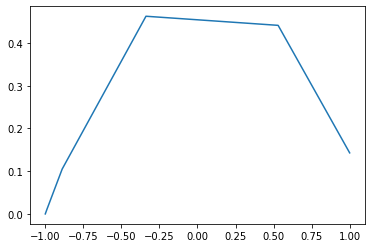

In [11]:
def f(x):
    return 1
def Q(x):
    return x**2
a, b = -1, 1
epsilon = 1
def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
y0 = np.array([0, 1])
sol = integ.solve_ivp(fun, [-1,1], y0)
plt.plot(sol['t'], sol['y'][0,:])

In [12]:
epsilon = 1
def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])

def y_final(v):
    y0 = np.array([0, v])
    sol = integ.solve_ivp(fun, [-1,1], y0)
    # La última columna de sol['y'] corresponde al tiempo final
    return sol['y'][0,-1]

In [13]:
y_final(1)

0.1428880884715334

## Apartado C1.1 (recuperación del control 1)

Encuentra una raíz $v_*$ de la función ``y_final`` en el intervalo $[0.5, 1.5]$. Representa gráficamente la solución del problema de valor inicial con 

$$ y(-1)=0, \quad \dot{y}(-1)=v_* $$

y compárala con la solución obtenida en el apartado 1.

In [14]:
from scipy.optimize import root

sol = root(y_final, 1)
sol

/tmp/ipykernel_34205/3917852485.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v])


    fjac: array([[-1.]])
     fun: -6.106226635438361e-16
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-6.28386232e-14])
       r: array([-2.27978612])
  status: 1
 success: True
       x: array([0.93732396])

In [15]:
v_star = sol['x']
y_final(v_star)

/tmp/ipykernel_34205/3917852485.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v])


-6.106226635438361e-16

> Dibujamos la solución del PVI con `[0, v_star]` como condición inicial
> La solución tiene pocos puntos porque el método adaptativo RK45 no necesita más

/tmp/ipykernel_34205/3959022262.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v_star])


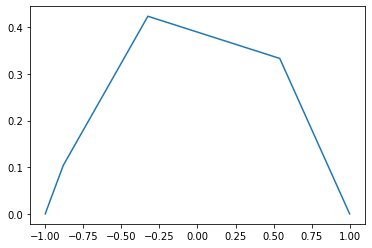

In [16]:
y0 = np.array([0, v_star])
sol = integ.solve_ivp(fun, [-1,1], y0)
plt.plot(sol['t'], sol['y'][0,:])

> Ampliando la cantidad de puntos `x`, la solución se parece mucho más a la obtenida con `solve_bvp`.

/tmp/ipykernel_34205/3320414462.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v_star])


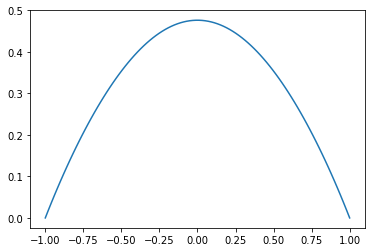

In [17]:
y0 = np.array([0, v_star])
x_eval = np.linspace(-1,1,100)
sol_ivp = integ.solve_ivp(fun, [-1,1], y0, t_eval=x_eval)
plt.plot(sol_ivp['t'], sol_ivp['y'][0,:])

> Comparamos en la misma gráfica

/tmp/ipykernel_34205/1192006611.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v_star])


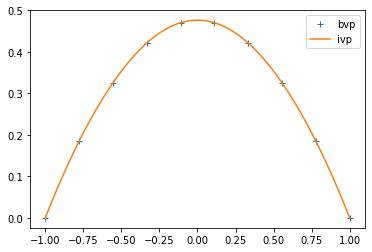

In [18]:
def f(x):
    return 1
def Q(x):
    return x**2
epsilon = 1

def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))
sol_bvp = integ.solve_bvp(fun, bc, xs, ys)
plt.plot(sol_bvp['x'], sol_bvp['y'][0,:], '+', label='bvp')


y0 = np.array([0, v_star])
x_eval = np.linspace(-1,1,100)
sol_ivp = integ.solve_ivp(fun, [-1,1], y0, t_eval=x_eval)
plt.plot(sol_ivp['t'], sol_ivp['y'][0,:], label='ivp')

plt.legend()

> Comparamos restando las soluciones en los mismos puntos: la diferencia es mínima

In [19]:
y0 = np.array([0, v_star])
x_eval = sol_bvp['x']
sol_ivp = integ.solve_ivp(fun, [-1,1], y0, t_eval=x_eval)
max(np.abs(sol_ivp['y'][0,:] - sol_bvp['y'][0,:]))

/tmp/ipykernel_34205/3438607874.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v_star])


0.0001543637222905514

## Apartado C1.2 (recuperación del control 1)

 - ¿Cuáles de las siguientes técnicas se pueden usar para interpolar el resultado obtenido al resolver el problema de valor inicial con el método Runge-Kutta 4,5? 
   + Polinomio interpolador de Lagrange
   + Nodos equiespaciados
   + Nodos de Chebyshev
   + Spline cúbica
 - Resuelve el PVI usando "Runge-Kutta 4,5", aplica uno de estos métodos de interpolación, a tu elección, y dibuja el resultado.

> No podemos usar ni nodos equiespaciados ni nodos de Chebyshev, porque el método Runge-Kutta 4,5 es adaptativo y no podemos elegir los pasos que usará. Pero podemos usar tanto Polinomio interpolador de Lagrange como Spline cúbica.

> Decidimos usar una spline cúbica para interpolar.

/tmp/ipykernel_34205/1943875192.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.array([0, v_star])


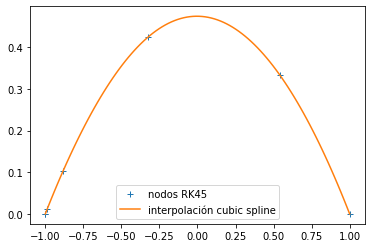

In [20]:
from scipy.interpolate import CubicSpline


y0 = np.array([0, v_star])
sol = integ.solve_ivp(fun, [-1,1], y0)

plt.plot(sol['t'], sol['y'][0,:], '+', label='nodos RK45')
cs3 = CubicSpline(sol['t'], sol['y'][0,:])
n = 100
x_eval = np.linspace(a, b, n)
u_eval = cs3(x_eval)
plt.plot(x_eval, u_eval, label='interpolación cubic spline')

plt.legend()

## Apartado 3 (2,5p.)

 - ¿Qué tipo de tarea está realizando el código siguiente? ¿Qué número o función intenta aproximar?
 - ¿Qué método numérico está usando para aproximar ese objeto matemático?
 - Aproxima el mismo objeto matemático con otro método numérico de tu elección.

In [21]:
from scipy.integrate import *
from fem2d_utils import *

def Area(vertices):
    P = np.ones((3,3))
    P[:,:2] = vertices
    return abs(la.det(P)/2)

def I(vertices, f):
    bar = vertices.sum(axis=0)/3
    return Area(vertices)*f(bar)

def IC(vertices, triangles, f):
    return sum(I(vertices[T], f) for T in triangles)

def f(xy):
    return np.sin(np.pi*xy[0])*xy[1]

ins = []

for N in [2,5,10]:
    vertices, ivertices_boundary, triangles = square_mesh(N, L=1)
    ins.append(IC(vertices, triangles, f))

In [32]:
ins

[0.34150635094610965, 0.3218340458523666, 0.3191846293263292]

## Apartado 3 (2,5p.)

 - ¿Qué tipo de tarea está realizando el código siguiente? ¿Qué número o función intenta aproximar?

> Está aproximando un número: una integral definida bidimensional, en concreto la integral de `f(x,y) = sin(pi*x)*y` en el cuadrado unidad `[0,1]x[0,1]`

 - ¿Qué método numérico está usando para aproximar ese objeto matemático?

> - Está usando una regla compuesta, donde la regla simple es la regla del baricentro para integrar una función 2D sobre un triángulo: regla del baricentro compuesta.

 - Aproxima el mismo objeto matemático con otro método numérico de tu elección.
 
> - Usamos la regla de los vértices y usamos también `dblquad`, aprovechando que el cuadrado unidad es una region simple.
> - Curiosidad: esta integral se puede hacer a mano por variables separadas: el resultado es 1/pi


In [22]:
from scipy.integrate import *
from fem2d_utils import *

def Area(vertices):
    P = np.ones((3,3))
    P[:,:2] = vertices
    return abs(la.det(P)/2)

def quad_vertices(vs, f):
    fv1, fv2, fv3 = f(vs[0,:]), f(vs[1,:]), f(vs[2,:])
    return Area(vs)*(fv1 + fv2 + fv3)/3

def quad_vertices_compuesta(vertices, triangles, f):
    return sum(quad_vertices(vertices[T], f) for T in triangles)

def f(xy):
    return np.sin(np.pi*xy[0])*xy[1]

for N in [2,5,10]:
    vertices, ivertices_boundary, triangles = square_mesh(N, L=1)
    print(IC(vertices, triangles, f), quad_vertices_compuesta(vertices, triangles, f))

0.34150635094610965 0.25
0.3218340458523666 0.30776835371752537
0.3191846293263292 0.31568757573375206


In [23]:
dblquad(lambda y,x:f([x,y]), 0, 1, lambda x:0, lambda x:1)

(0.3183098861837907, 5.551115123125783e-15)

In [24]:
# Curiosidad: esta integral se puede hacer a mano por variables separadas: el resultado es 1/pi
1/np.pi

0.3183098861837907

## Apartado 4. 

- (1,5 p.) Resuelve utilizando el método de diferencias finitas la ecuación de difusión:

$$ \partial_t u(t,x) = \partial_{xx} u(t,x),\quad 0<x<1, $$

con condiciones de contorno:

$$ u(t,0)=u(t,1)=0, $$

y condición inicial 

$$ u(0,x)= e^{-(x-0.5)^2/0.01}, $$

Representa gráficamente las solución en los instantes de tiempo $t=0,1,2,3,4,5$.

- (extra 1,5 p.) Resuelve utilizando un método de tu elección la ecuación de difusión:

$$ \partial_t u(t,x) = \partial_{xx} u(t,x) - Q(x)u(t,x),\quad -1<x<1, $$

con condiciones de contorno:

$$ u(t,-1)=u(t,1)=0, $$

y condición inicial 

$$ u(0,x)= e^{-x^2/0.01}, $$

para $Q(x)= x^2$ y $t\in[0,5]$.

Representa gráficamente las solución en los instantes de tiempo $t=0,1,2,3,4,5$.

> Comenzamos a plantear el método de diferencias finitas igual que hicimos para la ecuación de ondas: Reemplazamos la función inicial $u$ de una variable real por un vector con los valores de $u$ en los puntos de un mallado:

$$
\overrightarrow{u}=\left(u(x_1),\dots,u(x_j),\dots,u(x_{n-1})\right),\quad
x_j=x_0+j\cdot h
$$
> Observa que no incluimos $u(x_0)$ ni $u(x_n)$, porque son siempre 0 por definición.

> Reemplazamos la ecuación en derivadas parciales (con $c=1$):
$$
\partial_{t}u = \partial_{xx}u
$$
> por la siguiente ecuación diferencial ordinaria
$$
\partial_{t}\overrightarrow{u} = D\cdot \overrightarrow{u}
$$
> donde $D$ es un operador de diferencias finitas (que aprovecha que $u(x_0)=u(x_n)=0$):
$$
D\cdot \overrightarrow{u}=\left(\frac{-2u(x_1)+u(x_{2})}{h^2},
\frac{u(x_{1})-2u(x_2)+u(x_{3})}{h^2},
\dots,
\frac{u(x_{j-1})-2u(x_j)+u(x_{j+1})}{h^2},\dots\right)
$$

> La matriz $D$ es la misma que vimos en la ecuación de ondas, ya que aproxima el mismo operador diferencial:
$$D=\frac{-1}{h^2}\left(\begin{array}{rrrrr}
2.0 & -1.0 & 0.0 & 0.0 & 0.0 \\
-1.0 & 2.0 & -1.0 & 0.0 & 0.0 \\
0.0 & -1.0 & 2.0 & -1.0 & 0.0 \\
0.0 & 0.0 & -1.0 & 2.0 & -1.0 \\
0.0 & 0.0 & 0.0 & -1.0 & 2.0
\end{array}\right)$$

> Fé de erratas: en el cuaderno `ondas` aparecía con el signo cambiado, pero el código era todo correcto.

# Ecuación del calor con diferencias finitas

> Como el tiempo avanza desde la solución inicial, podemos aproximar la derivada $u_{t}$ así:

$$
\partial_{t}u(t_{j},x)\approx \frac{u(t_{j+1},x) - u(t_j,x)}{k}
$$
> para un _paso temporal $k$_. Ésto nos permite avanzar en el tiempo de esta forma:
$$
\begin{array}{lcl}
\overrightarrow{u}_{j+1} &=& \overrightarrow{u}_j + k D\cdot \overrightarrow{u}_j
\end{array}
$$
> Simplicamos el código de la ecuación de ondas:

/tmp/ipykernel_34205/1104731912.py:27: RuntimeWarning: overflow encountered in matmul
  u_new = ut_int + k*A@ut_int
/tmp/ipykernel_34205/1104731912.py:27: RuntimeWarning: invalid value encountered in matmul
  u_new = ut_int + k*A@ut_int


Text(0.5, 1.0, 'Integración temporal con Euler del problema espacial discretizado')

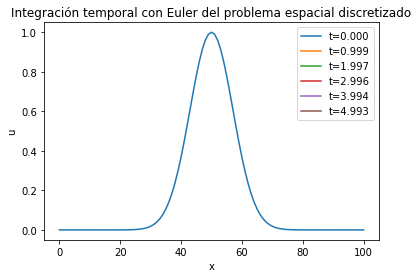

In [25]:
def init_fn(x):
    return np.exp(-(x-.5)**2/0.01)

def diff_fin_matrix(n):
    return np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

L  = 1
Nx = 100
h  = L/Nx

t0 = 0
tf = 5
Nt = 700
k  = (tf - t0)/Nt

lamb = k/h

xs = np.linspace(0, L , Nx+1)
xs_int = xs[1:-1]
u0 = init_fn(xs_int)

A = -(1/h**2)*diff_fin_matrix(Nx-1)
u = np.zeros((Nt+1,Nx+1)) #solution to WE
u[0,1:-1] = u0
for j in range(Nt):
    ut_int = u[j,1:-1]
    u_new = ut_int + k*A@ut_int
    u[j+1,1:-1] = u_new

for t in np.linspace(0, Nt-1, 6):
    plt.plot(u[int(t),:], label='t=%.3f'%(t*k))
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Integración temporal con Euler del problema espacial discretizado')

> - Observamos que la gráfica es extraña: no vemos la solución para t= 1, 2, ... 5
> - Comprobamos que los avisos ` RuntimeWarning: overflow encountered in matmul` no han sido en vano, y la solución explota, como ocurría con la ecuación de ondas

In [26]:
u[100,:]

array([ 0.00000000e+000,  1.67059528e+231, -3.24347584e+231,
        4.63036021e+231, -5.76057080e+231,  6.58689426e+231,
       -7.08847045e+231,  7.27052709e+231, -7.16125598e+231,
        6.80651643e+231, -6.26329206e+231,  5.59288930e+231,
       -4.85476233e+231,  4.10162101e+231, -3.37618422e+231,
        2.70964465e+231, -2.12166243e+231,  1.62153740e+231,
       -1.21013330e+231,  8.82133860e+230, -6.28277851e+230,
        4.37321828e+230, -2.97588529e+230,  1.98056207e+230,
       -1.29017530e+230,  8.23819128e+229, -5.17145697e+229,
        3.21049633e+229, -1.99439477e+229,  1.26695900e+229,
       -8.52159673e+228,  6.32684156e+228, -5.32523619e+228,
        5.03635348e+228, -5.16220655e+228,  5.51945624e+228,
       -5.99406900e+228,  6.51223479e+228, -7.02256605e+228,
        7.48584560e+228, -7.86966971e+228,  8.14616806e+228,
       -8.29157855e+228,  8.28685418e+228, -8.11873615e+228,
        7.78089195e+228, -7.27482967e+228,  6.61038748e+228,
       -5.80567401e+228,

> - Aumentamos el paso temporal para que la solución converja (¡es un método de Euler explícito, es normal que diverja y aumentar el paso arregla el problema!). Es necesario aumentar el paso mucho respecto del paso espacial (consecuencia de que para el paso espacial usamos una diferencia de orden 2 y para el paso temporal hemos usado una diferencia de orden 1).

Text(0.5, 1.0, 'Integración temporal con Euler del problema espacial discretizado')

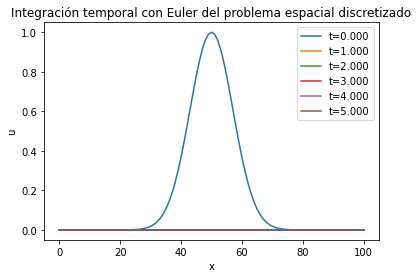

In [27]:
def init_fn(x):
    return np.exp(-(x-.5)**2/0.01)

def diff_fin_matrix(n):
    return np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

L  = 1
Nx = 100
h  = L/Nx

t0 = 0
tf = 5
Nt = 100000
k  = (tf - t0)/Nt

lamb = k/h

xs = np.linspace(0, L , Nx+1)
xs_int = xs[1:-1]
u0 = init_fn(xs_int)

A = -(1/h**2)*diff_fin_matrix(Nx-1)
u = np.zeros((Nt+1,Nx+1)) #solution to WE
u[0,1:-1] = u0
for j in range(Nt):
    ut_int = u[j,1:-1]
    u_new = ut_int + k*A@ut_int
    u[j+1,1:-1] = u_new

for t in np.linspace(0, Nt-1, 6):
    plt.plot(u[int(t),:], label='t=%.3f'%(t*k))
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Integración temporal con Euler del problema espacial discretizado')

> - La solución es un poco _'extraña'_, pero no hay problema de inestabilidad, y es la solución correcta: el calor se disipa casi por completo en tiempo 1. Poniendo más fotogramas, o reduciendo el tiempo final, apreciamos la evolución del perfil de calor:

Text(0.5, 1.0, 'Integración temporal con Euler del problema espacial discretizado')

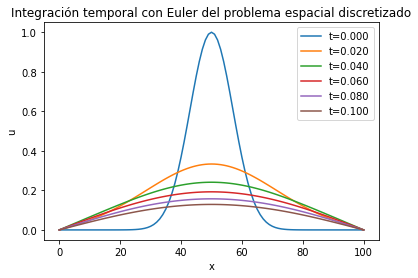

In [28]:
def init_fn(x):
    return np.exp(-(x-.5)**2/0.01)

def diff_fin_matrix(n):
    return np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

L  = 1
Nx = 100
h  = L/Nx

t0 = 0
tf = 0.1
Nt = 100000
k  = (tf - t0)/Nt

lamb = k/h

xs = np.linspace(0, L , Nx+1)
xs_int = xs[1:-1]
u0 = init_fn(xs_int)

A = -(1/h**2)*diff_fin_matrix(Nx-1)
u = np.zeros((Nt+1,Nx+1)) #solution to WE
u[0,1:-1] = u0
for j in range(Nt):
    ut_int = u[j,1:-1]
    u_new = ut_int + k*A@ut_int
    u[j+1,1:-1] = u_new

for t in np.linspace(0, Nt-1, 6):
    plt.plot(u[int(t),:], label='t=%.3f'%(t*k))
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Integración temporal con Euler del problema espacial discretizado')

Text(0.5, 1.0, 'Integración temporal con Euler del problema espacial discretizado')

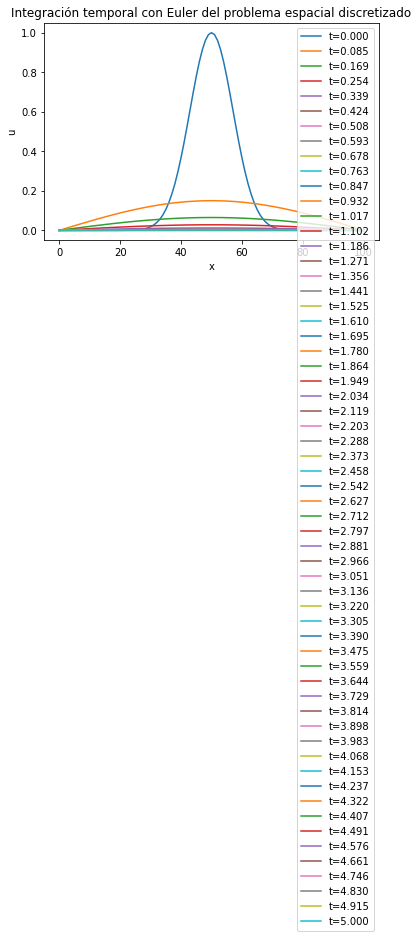

In [29]:
def init_fn(x):
    return np.exp(-(x-.5)**2/0.01)

def diff_fin_matrix(n):
    return np.diag(2*np.ones(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

L  = 1
Nx = 100
h  = L/Nx

t0 = 0
tf = 5
Nt = 100000
k  = (tf - t0)/Nt

lamb = k/h

xs = np.linspace(0, L , Nx+1)
xs_int = xs[1:-1]
u0 = init_fn(xs_int)

A = -(1/h**2)*diff_fin_matrix(Nx-1)
u = np.zeros((Nt+1,Nx+1)) #solution to WE
u[0,1:-1] = u0
for j in range(Nt):
    ut_int = u[j,1:-1]
    u_new = ut_int + k*A@ut_int
    u[j+1,1:-1] = u_new

for t in np.linspace(0, Nt-1, 60):
    plt.plot(u[int(t),:], label='t=%.3f'%(t*k))
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Integración temporal con Euler del problema espacial discretizado')

> - Conclusión: esta técnica no es la mejor para esta ecuación, que se puede resolver de forma exacta usando la serie de senos, un método adaptativo para la evolución temporal, o una diferencia de orden 2 para el paso temporal, entre otros...